# Raster data handling with rasterio

In this Notebook we open and explore two spectral bands from the Sentinel-2 satellite, calculate the NDVI and save the NDVI raster to a GeoTiff. Along this way, we touch a couple of issues related to raster handling using the [rasterio](https://rasterio.readthedocs.io/en/stable/) package. Towards the end of the Notebook, we have a look at how files with multiple bands can be handled with rasterio.

## Read Sentinel-2 bands

Define the bands to open with rasterio. Rasterio's ``open()`` function returns an opened dataset object.

In [51]:
import rasterio
from pathlib import Path
data_dir = Path('F:/OneDrive - uibk.ac.at/FE_WS2324/data')      # Set your local path to the data
b04 = rasterio.open(data_dir / 'S2' / 'T32TPT_20201122T102339_B04_10m.jp2')     # This is the red band
b08 = rasterio.open(data_dir / 'S2' / 'T32TPT_20201122T102339_B08_10m.jp2')     # This is the NIR band

Once `rasterio.open()` has established a file connection, we can access two types of data from the of the opened dataset object:

* the `numpy` array containing the raster values (in a single band raster one value per pixel (raster cell))
* and a dictionary with the metadata.

<center>
<img src="toolbox_media/rasterio-structure.png" title="Rasterio structure" width="800">
</center>

Have a look at georeferencing attributes and other metadata stored with the Band 4 raster, namely

* 'Geotransform': Affine transformation matrix that maps pixel locations from image space ((col, row) coordinates) to georeferenced (projected or geographic) coordinates (basically you can see the spatial resolution/pixel size and the upper left corner coordinates, more details [here](https://rasterio.readthedocs.io/en/latest/topics/georeferencing.html#affine))
* Coordinate reference system (CRS) where spatial positions relate to
* Shape and bounding box
* Number of bands in the image
* Data type used to store the data

In [20]:
print(b04.transform)    # Affine transformation matrix
print(b04.crs)          # Coordinate reference system EPSG code
print(b04.shape)        # Shape of b04 (number of pixels in both dimensions)
print(b04.bounds)       # Bounding box
print(b04.count)        # Band count
print(b04.dtypes)       # Data type

| 10.00, 0.00, 600000.00|
| 0.00,-10.00, 5300040.00|
| 0.00, 0.00, 1.00|
EPSG:32632
1
(10980, 10980)
BoundingBox(left=600000.0, bottom=5190240.0, right=709800.0, top=5300040.0)
('uint16',)


... or simply print all the metadata.

In [21]:
print(b04.meta)

{'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 1, 'crs': CRS.from_epsg(32632), 'transform': Affine(10.0, 0.0, 600000.0,
       0.0, -10.0, 5300040.0)}


Read the bands, which returns a ``numpy.ndarray``. As seen in the metadata, this contains unsigned integer values but we want the pixel values as float, so that the NDVI computed in a later step will be float as well. Therefore, we read the bands data and convert the data type. We tell rasterio to read the band 1 in this raster file although this is actually not needed here because it's a single band file.

Why do the bands contain integers - reflectance should be between 0 and 1? That's because the values have been scaled by a factor of 10000 to store the same information in smaller files.

In [22]:
a04 = b04.read(1).astype(float)
a08 = b08.read(1).astype(float)

For the bands opened as numpy arrays, we can perform various array operations, for instance calculate basic statistics.

In [23]:
print(a04.min())
print(a04.max())
print(a04.mean())

0.0
16080.0
1473.3225049269909


## Plotting

Plot one band using rasterio's built-in ``show()`` method.

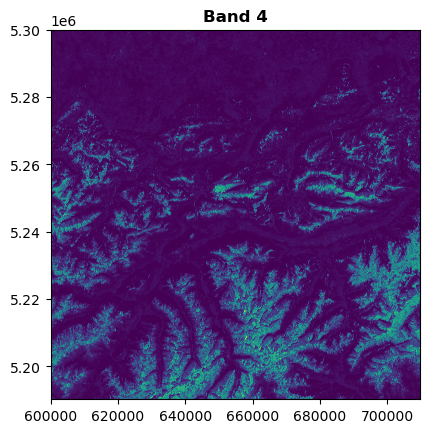

<Axes: title={'center': 'Band 4'}>

In [24]:
from rasterio.plot import show
show(b04, title='Band 4')

## Calculate the NDVI

Now we calculate the [normalized difference vegetation index](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index) (NDVI) from the float bands.

In [41]:
ndvi = (a08-a04)/(a08+a04)

C:\Users\Andi\AppData\Local\Temp\ipykernel_2500\2912796907.py:1: RuntimeWarning: invalid value encountered in divide
  ndvi = (a08-a04)/(a08+a04)


## Write the NDVI to a GeoTiff

In [53]:
with rasterio.open(
    data_dir / 'S2' / 'ndvi.tif',       # output file
    mode="w",                           # write mode
    driver="GTiff",                     # Specify the driver (here GeoTiff)
    height=b04.shape[0],                # number of rows of the raster
    width=b04.shape[1],                 # number of columns of the raster
    count=1,                            # a count of the raster bands (NDVI is only one band)
    dtype=a04.dtype,                    # data type (same as for a04, i.e. the float version of the array)
    crs=b04.crs,                        # write the same CRS as one of the source bands has
    transform=b04.transform             # write the same transform as one of the source bands has
) as new_dataset:
    new_dataset.write(ndvi, 1)           # write NDVI data to band at location 1

## Close datasets

As Python `file` objects can, Rasterio datasets can manage the entry into and exit from runtime contexts created using a `with` statement. This initiates a context manager that ensures that files are automatically closed after use, no matter what exceptions may be raised within the block. We have used such a context manager in the previous cell for writing the NDVI raster to a file. For the input datasets we did not do this, so they are still open and we should close them (read [here](https://realpython.com/why-close-file-python/) why).

In [49]:
# Band 4
print(b04.closed)
b04.close()
print(b04.closed)

# Band 8
print(b08.closed)
b08.close()
print(b08.closed)

False
True
False
True


## Plotting raster data

Try plotting the NDVI raster with matplotlib ...

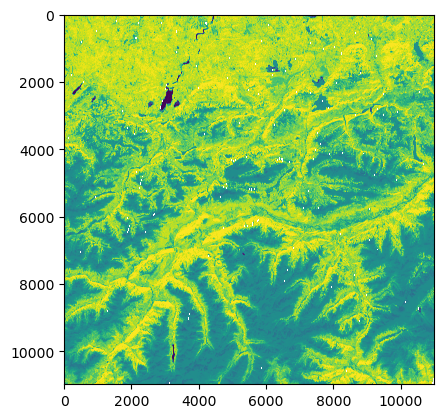

In [61]:
import matplotlib.pyplot as plt
with rasterio.open(data_dir / 'S2' / 'ndvi.tif') as src:
    plt.imshow(src.read(1))

... and with rasterio's built-in plotting methods. What's the difference?

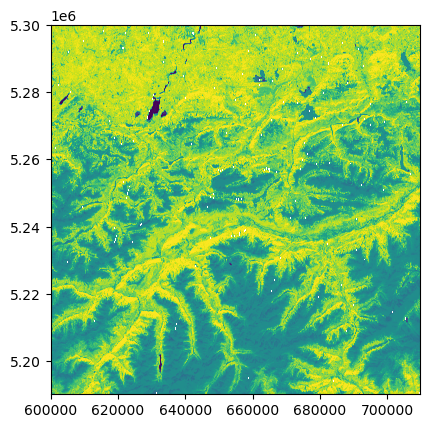

In [62]:
from rasterio.plot import show
with rasterio.open(data_dir / 'S2' / 'ndvi.tif') as src:
    show(src.read(), transform=src.transform)       # Use the transform attribute to get CRS coordinates.

An advantage of rasterio's `plot()` is that we can use the transform attribute to easily get CRS coordinates. Unfortunately, it does not support a colorbar - but matplotlib's `imshow()` does so. To get both the proper coordinates and the colorbar, we use a trick: Plot with the two methods on the same axes.

We can also try another one of the [pre-defined colormaps](https://matplotlib.org/stable/users/explain/colors/colormaps.html). And we plot a histogram in the same figure, next to the NDVI map.

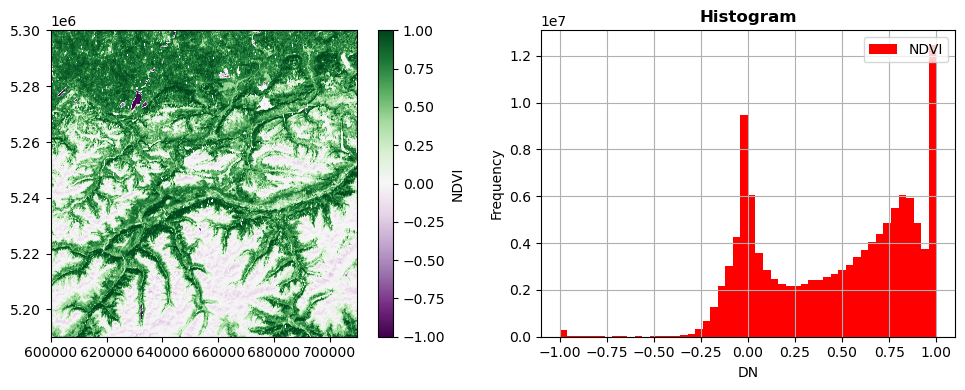

In [88]:
from rasterio.plot import show_hist

with rasterio.open(data_dir / 'S2' / 'ndvi.tif') as src:

    # Read the raster data
    data = src.read(1)
    
    # Create a figure with two subplots (axes)
    fig, ax = plt.subplots(1, 2, figsize=(10,4))

    # Use matplotlib's imshow() to plot the data as image to the first subplot, define a named colormap
    image = ax[0].imshow(data, cmap='PRGn')                 # Only needed for the colorbar
    fig.colorbar(image, label='NDVI', ax=ax[0])             # Add a colorbar to the image in the first subplot

    # Use rasterio's show() to plot the data as image to the first subplot AGAIN, define the geotransform
    show(data, cmap='PRGn', transform=src.transform, ax=ax[0])
    
    # Plot the data as a histogram to the second subplot
    show_hist(src, bins=50, label='NDVI', ax=ax[1])
    
    # Make it look nicer (prevent that labels of different axes overlap each other)
    fig.tight_layout()

## Imagery with multiple bands

So far we have worked on single band rasters for reading, writing and plotting. Image file formats, however, can store multiple spectral bands in one file. In the following cell we read a small subset from a Sentinel-2 satellite image. Clouds and cloud shadows have been masked, i.e. they are set to zero (the NoData value of this image). Six of the bands available in Sentinel-2 datasets are stored in a GeoTiff, the first three bands are blue, green and red.

Rasterio can show color composites but for this we need to write the the bands that we want to display into a new 3-band file with values ranging from 0 to 1. To enhance the contrast in the image, we apply a percentile clip (you may experiment with these clip values and see how this effects the plot in the following cells!).

In [218]:
import numpy as np

in_file = data_dir / 'S2' / '20180726T102019_20180726T102150_T32TPS.tif' # Specify the path and the filename of an image

# Define what parts of the value distribution are clipped
lower_pct = 2       # The smallest percentile that will be clipped (try e.g. 10)
upper_pct = 98      # The largest percentile that will be clipped (try e.g. 99)

# Define a percentile clip function
def pct_clip(array,pct=[lower_pct,upper_pct]):
    array_min, array_max = np.nanpercentile(array,pct[0]), np.nanpercentile(array,pct[1])
    clip = (array - array_min) / (array_max - array_min)
    clip[clip>1]=1
    clip[clip<0]=0
    return clip

with rasterio.open(in_file) as src:

    # Read RGB bands, convert to float, apply scale factor, then apply percentile clip
    red = pct_clip(src.read(3).astype(float)/10000)
    green = pct_clip(src.read(2).astype(float)/10000)
    blue = pct_clip(src.read(1).astype(float)/10000)

    # Copy metadata of source file to use as destination file metadata
    dst_meta = src.meta.copy()
    dst_meta.update({'count': 3, 'dtype': 'float32'})   # Update only the band count and the data type

    # Write the RGB bands to a 3-band GeoTiff
    with rasterio.open(
        data_dir / 's2' / 'rgb.tif',
        'w',
        **dst_meta
        ) as dst:
        dst.write(red, 1)       # Write red band raster to first band of the file
        dst.write(green, 2)     # Write green band raster to second band of the file
        dst.write(blue, 3)      # Write blue band raster to third band of the file

Now we can read this RGB image and show it as true-color image. Black areas are NoData (the result of cloud masking). The image shows a small area around the village of Obergurgl (Austria).

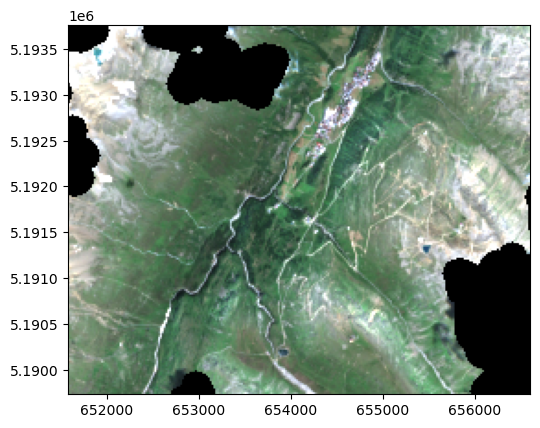

In [202]:
with rasterio.open(data_dir / 's2' / 'rgb.tif') as src:
    show(src.read(), transform=src.transform)

And finally we plot the histogram fro the three bands.

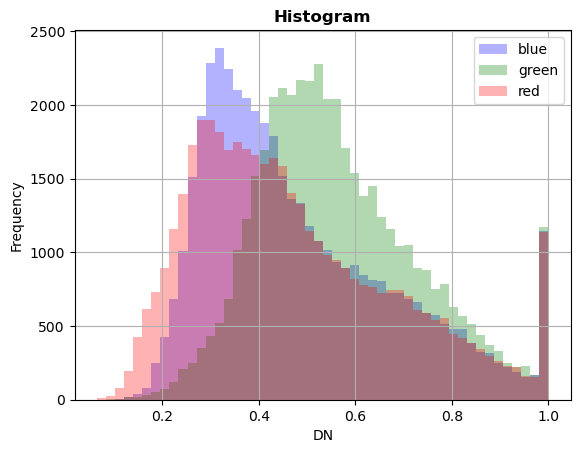

In [208]:
with rasterio.open(data_dir / 's2' / 'rgb.tif') as src:
    show_hist(src, bins=50, histtype='stepfilled', lw=0.0, stacked=False, alpha=0.3, label=('red','green','blue'))

We have seen that rasterio can handle files with multiple bands and we can flexibly work with these bands. However, this comes with some complexity of the required code and when we introduce time as an additional dimension it becomes rather impractical. In the next tutorials we explore how the `xarray` package helps with multiple bands and then even with multispectral time series.